## Linear Regression

Simple notebook to illustrate using linear regression to predict returns. Here is an example of using 5 features which are lagged returns 1 through 5 days.


### Imports and Specifying Parameters


In [ ]:
import ccxt
import pandas as pd
import numpy as np

symbol = 'BTC/USDT'
timeframe = '1d'
exchange = ccxt.binance()

### Fetching Full OHLCV History


In [ ]:
def fetch_full_history(exchange, symbol, timeframe, start_date=None):
    if start_date is None:
        since = 0  # Start from the earliest available data
    elif start_date is not None:
        since = int(pd.Timestamp(start_date).timestamp() * 1000)
    all_data = []
    while True:
        try:
            price_data = exchange.fetch_ohlcv(
                symbol, timeframe, since)
            if not price_data:
                break
            all_data.extend(price_data)
            since = price_data[-1][0] + 1

        except Exception as e:
            print(type(e).__name__, str(e))

    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df['returns'] = np.log(df.close / df.close.shift(1))
    return df


df = fetch_full_history(exchange, symbol, timeframe)

print(df)

### Creating Lags


In [16]:
def create_lags(df, lags):
    names = []
    for i in range(1, lags + 1):
        df["lag_" + str(i)] = df["returns"].shift(i)
        names.append("lag_" + str(i))
    return names


lag_names = create_lags(df, 5)
df.dropna(inplace=True)
df

### Fit Lag Features


In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df[lag_names], df["returns"])

df["prediction_LR"] = model.predict(df[lag_names])
df

,timestamp,open,high,low,close,volume,returns,lag_1,lag_2,lag_3,lag_4,lag_5,prediction_LR
date,,,,,,,,,,,,,
2017-08-23,1503446400000,4040.00,4265.80,4013.89,4114.01,1001.136565,0.018154,0.005958,-0.017351,-0.013053,0.007665,-0.042113,-0.001063
2017-08-24,1503532800000,4147.00,4371.68,4085.01,4316.01,787.418753,0.047933,0.018154,0.005958,-0.017351,-0.013053,0.007665,0.000203
2017-08-25,1503619200000,4316.01,4453.91,4247.48,4280.68,573.612740,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053,-0.001028
2017-08-26,1503705600000,4280.71,4367.00,4212.41,4337.44,228.108068,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,0.003573
2017-08-27,1503792000000,4332.51,4400.00,4285.54,4310.01,350.692585,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,0.001039
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,1716163200000,66274.00,71515.56,66060.31,71446.62,50816.701100,0.075153,-0.009628,-0.001625,0.027051,-0.014779,0.072482,0.003411
2024-05-21,1716249600000,71446.62,71979.00,69162.94,70148.34,49607.433600,-0.018338,0.075153,-0.009628,-0.001625,0.027051,-0.014779,-0.003315
2024-05-22,1716336000000,70148.34,70666.00,68842.19,69166.62,27673.180260,-0.014094,-0.018338,0.075153,-0.009628,-0.001625,0.027051,0.005889


### Assign trade position

If the predicted return is positive we assign the value to 1 indicating a long. Negative we assign -1 indicating a short


In [19]:
df["direction_LR"] = [1 if i > 0 else -1 for i in df.prediction_LR]
df

,timestamp,open,high,low,close,volume,returns,lag_1,lag_2,lag_3,lag_4,lag_5,prediction_LR,direction_LR
date,,,,,,,,,,,,,,
2017-08-23,1503446400000,4040.00,4265.80,4013.89,4114.01,1001.136565,0.018154,0.005958,-0.017351,-0.013053,0.007665,-0.042113,-0.001063,-1
2017-08-24,1503532800000,4147.00,4371.68,4085.01,4316.01,787.418753,0.047933,0.018154,0.005958,-0.017351,-0.013053,0.007665,0.000203,1
2017-08-25,1503619200000,4316.01,4453.91,4247.48,4280.68,573.612740,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053,-0.001028,-1
2017-08-26,1503705600000,4280.71,4367.00,4212.41,4337.44,228.108068,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,0.003573,1
2017-08-27,1503792000000,4332.51,4400.00,4285.54,4310.01,350.692585,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,0.001039,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,1716163200000,66274.00,71515.56,66060.31,71446.62,50816.701100,0.075153,-0.009628,-0.001625,0.027051,-0.014779,0.072482,0.003411,1
2024-05-21,1716249600000,71446.62,71979.00,69162.94,70148.34,49607.433600,-0.018338,0.075153,-0.009628,-0.001625,0.027051,-0.014779,-0.003315,-1
2024-05-22,1716336000000,70148.34,70666.00,68842.19,69166.62,27673.180260,-0.014094,-0.018338,0.075153,-0.009628,-0.001625,0.027051,0.005889,1


### Calculate Strategy Returns

We calculate strategy returns by taking the trade direction multiplying by returns. If the direction was -1 (short) and the actual returns was negative (-0.05 for example),
then the strategy return for that day was 0.05 and vice versa for long


In [20]:
df["strategy_LR"] = df["direction_LR"] * df["returns"]
df

,timestamp,open,high,low,close,volume,returns,lag_1,lag_2,lag_3,lag_4,lag_5,prediction_LR,direction_LR,strategy_LR
date,,,,,,,,,,,,,,,
2017-08-23,1503446400000,4040.00,4265.80,4013.89,4114.01,1001.136565,0.018154,0.005958,-0.017351,-0.013053,0.007665,-0.042113,-0.001063,-1,-0.018154
2017-08-24,1503532800000,4147.00,4371.68,4085.01,4316.01,787.418753,0.047933,0.018154,0.005958,-0.017351,-0.013053,0.007665,0.000203,1,0.047933
2017-08-25,1503619200000,4316.01,4453.91,4247.48,4280.68,573.612740,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053,-0.001028,-1,0.008219
2017-08-26,1503705600000,4280.71,4367.00,4212.41,4337.44,228.108068,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,0.003573,1,0.013172
2017-08-27,1503792000000,4332.51,4400.00,4285.54,4310.01,350.692585,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,0.001039,1,-0.006344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,1716163200000,66274.00,71515.56,66060.31,71446.62,50816.701100,0.075153,-0.009628,-0.001625,0.027051,-0.014779,0.072482,0.003411,1,0.075153
2024-05-21,1716249600000,71446.62,71979.00,69162.94,70148.34,49607.433600,-0.018338,0.075153,-0.009628,-0.001625,0.027051,-0.014779,-0.003315,-1,0.018338
2024-05-22,1716336000000,70148.34,70666.00,68842.19,69166.62,27673.180260,-0.014094,-0.018338,0.075153,-0.009628,-0.001625,0.027051,0.005889,1,-0.014094


### Find cumulative strategy returns and plot it


In [21]:
np.exp(df[["returns", "strategy_LR"]].sum())

returns         16.652792
strategy_LR    190.128575
dtype: float64

<Axes: xlabel='date'>

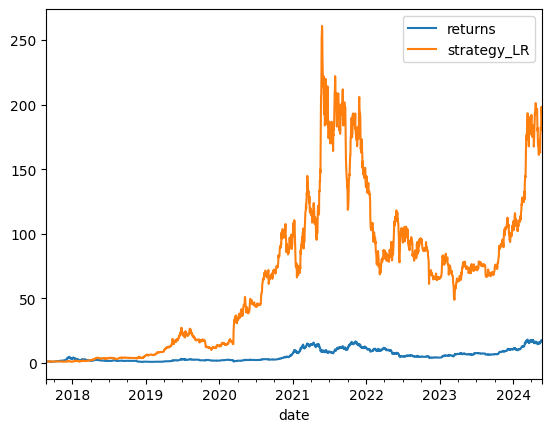

In [22]:
np.exp(df[["returns", "strategy_LR"]].cumsum()).plot()

### Unrealistic Returns

As you can see, this is unrealistic returns so lets, split our data into a training dataset and a testing data set. Training will be used to fit the data. Then we will use this training fitted model to test on the testing dataset.


In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, shuffle=False, test_size=0.3, random_state=0)
train = train.copy()
test = test.copy()

train

,timestamp,open,high,low,close,volume,returns,lag_1,lag_2,lag_3,lag_4,lag_5,prediction_LR,direction_LR,strategy_LR
date,,,,,,,,,,,,,,,
2017-08-23,1503446400000,4040.00,4265.80,4013.89,4114.01,1001.136565,0.018154,0.005958,-0.017351,-0.013053,0.007665,-0.042113,-0.001063,-1,-0.018154
2017-08-24,1503532800000,4147.00,4371.68,4085.01,4316.01,787.418753,0.047933,0.018154,0.005958,-0.017351,-0.013053,0.007665,0.000203,1,0.047933
2017-08-25,1503619200000,4316.01,4453.91,4247.48,4280.68,573.612740,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053,-0.001028,-1,0.008219
2017-08-26,1503705600000,4280.71,4367.00,4212.41,4337.44,228.108068,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,0.003573,1,0.013172
2017-08-27,1503792000000,4332.51,4400.00,4285.54,4310.01,350.692585,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,0.001039,1,-0.006344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,1652140800000,30074.23,32658.99,29730.40,31017.10,165532.003110,0.030801,-0.123751,-0.041265,-0.015147,-0.014861,-0.082337,0.003417,1,0.030801
2022-05-11,1652227200000,31017.11,32162.59,27785.00,29103.94,207063.739278,-0.063665,0.030801,-0.123751,-0.041265,-0.015147,-0.014861,-0.007123,-1,0.063665
2022-05-12,1652313600000,29103.94,30243.00,26700.00,29029.75,204507.263138,-0.002552,-0.063665,0.030801,-0.123751,-0.041265,-0.015147,0.003284,1,-0.002552


In [24]:
test

,timestamp,open,high,low,close,volume,returns,lag_1,lag_2,lag_3,lag_4,lag_5,prediction_LR,direction_LR,strategy_LR
date,,,,,,,,,,,,,,,
2022-05-15,1652572800000,30086.74,31460.00,29480.00,31328.89,46275.66912,0.040456,0.026939,0.008824,-0.002552,-0.063665,0.030801,0.000021,1,0.040456
2022-05-16,1652659200000,31328.89,31328.90,29087.04,29874.01,73082.19658,-0.047552,0.040456,0.026939,0.008824,-0.002552,-0.063665,-0.001215,-1,0.047552
2022-05-17,1652745600000,29874.01,30788.37,29450.38,30444.93,56724.13307,0.018931,-0.047552,0.040456,0.026939,0.008824,-0.002552,0.005793,1,0.018931
2022-05-18,1652832000000,30444.93,30709.99,28654.47,28715.32,59749.15799,-0.058489,0.018931,-0.047552,0.040456,0.026939,0.008824,-0.000949,-1,0.058489
2022-05-19,1652918400000,28715.33,30545.18,28691.38,30319.23,67877.36415,0.054351,-0.058489,0.018931,-0.047552,0.040456,0.026939,0.005453,1,0.054351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,1716163200000,66274.00,71515.56,66060.31,71446.62,50816.70110,0.075153,-0.009628,-0.001625,0.027051,-0.014779,0.072482,0.003411,1,0.075153
2024-05-21,1716249600000,71446.62,71979.00,69162.94,70148.34,49607.43360,-0.018338,0.075153,-0.009628,-0.001625,0.027051,-0.014779,-0.003315,-1,0.018338
2024-05-22,1716336000000,70148.34,70666.00,68842.19,69166.62,27673.18026,-0.014094,-0.018338,0.075153,-0.009628,-0.001625,0.027051,0.005889,1,-0.014094


In [26]:
model = LinearRegression()
model.fit(train[lag_names], train['returns'])
test["prediction_LR"] = model.predict(test[lag_names])
test["direction_LR"] = [1 if i > 0 else -1 for i in test.prediction_LR]
test["strategy_LR"] = test["direction_LR"] * test["returns"]
np.exp(test[["returns", "strategy_LR"]].sum())

returns        2.236111
strategy_LR    1.920295
dtype: float64

<Axes: xlabel='date'>

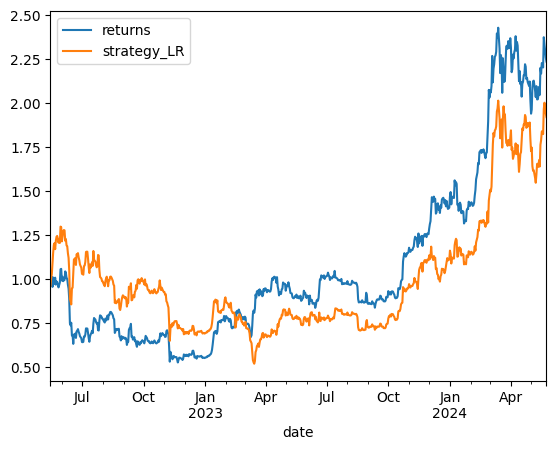

In [28]:
np.exp(test[["returns", "strategy_LR"]].cumsum()).plot()

### Count how many trades


In [29]:
(test['direction_LR'].diff() != 0).value_counts()

direction_LR
False    453
True     288
Name: count, dtype: int64

: 